In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.0 MB/s eta 0:00:00


In [ ]:
import glob
import os
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import random
from google.colab import files
import matplotlib.pyplot as plt

import cv2
import mtcnn
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt

from PIL import Image
import pickle
import nltk
from collections import Counter
import torch.utils.data as data
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
import time

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Facial Landmark Detection

In [ ]:
# 얼굴의 bounding box 그리기
def draw_bboxes(img, bboxes):
  x1, y1, w, h = bboxes['box']
  cv2.rectangle(img, (x1, y1), (x1+w,y1+h), (0,255,0), 2)

In [ ]:
# 눈, 코, 입 좌표 마킹
def mark_facial_landmarks(img, landmarks):
  cv2.circle(img, (landmarks), 1, (0,255,0), 2)

In [ ]:
men_path_list = glob.glob('/content/drive/MyDrive/AI-project/data/men/*')
men_img_list = [path for path in men_path_list if path.endswith('.jpg')]
women_path_list = glob.glob('/content/drive/MyDrive/AI-project/data/women/*')
women_img_list = [path for path in women_path_list if path.endswith('.jpg')]

print(len(men_img_list))
print(len(women_img_list))

9429
10000


In [ ]:
# 얼굴 면적
def face_area(detection, idx):
  w = detection[idx][0]['box'][2]
  h = detection[idx][0]['box'][3]
  area = w*h
  return area

In [ ]:
# 얼굴 가로 길이 기준 입술 길이 비율
def size_mouth(detection, idx):
  left_x = detection[idx][0]['keypoints']['mouth_left'][0]
  left_y = detection[idx][0]['keypoints']['mouth_left'][1]
  right_x = detection[idx][0]['keypoints']['mouth_right'][0]
  right_y = detection[idx][0]['keypoints']['mouth_right'][1]
  w = detection[idx][0]['box'][2]
  face = face_area(detection, idx)
  size = ((left_x-right_x)**2+(right_x-right_y)**2)**0.5 / w
  return size

In [ ]:
# 코 길이
# 눈을 직선으로 잇고 코와의 거리를 구함
def size_nose(detection, idx):
  a = detection[idx][0]['keypoints']['left_eye'][0]
  b = detection[idx][0]['keypoints']['left_eye'][1]
  c = detection[idx][0]['keypoints']['right_eye'][0]
  d = detection[idx][0]['keypoints']['right_eye'][1]

  nose_x = detection[idx][0]['keypoints']['nose'][0]
  nose_y = detection[idx][0]['keypoints']['nose'][1]

  m1 = b-d
  m2 = a-c

  size = abs(m1*nose_x - m2*nose_y - m1*a + m2*b)/(m1**2+m2**2)

  return size

# Selected Image Captioning

> Flickr8k 이미지 데이터셋으로 먼저 ResNet152-LSTM 모델을 학습시킨 후, 위에서 선택된 이미지(satisfied_img)에 대해서 captioning test 진행




---



In [ ]:
# Flickr8k 이미지 다운로드
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXVy7_7pF5FIsPp6WfXXfWgBNfUKx8N1VrTisN8FbGYG9w?download=1 -O Flickr8k_dataset.zip

--2023-06-18 09:43:40--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXVy7_7pF5FIsPp6WfXXfWgBNfUKx8N1VrTisN8FbGYG9w?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/datasets/Flickr8k_dataset.zip?ga=1 [following]
--2023-06-18 09:43:41--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/datasets/Flickr8k_dataset.zip?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1112971163 (1.0G) [application/x-zip-compressed]
Saving to: ‘Flickr8k_dataset.zip’

Flickr8k_dataset.zi 100%[===================>]   1.04G  93.5MB/s    in 13s     

2023-06-18 0

In [ ]:
%%capture
!unzip Flickr8k_dataset.zip -d ./Flickr8k_dataset

In [ ]:
img_dir = './Flickr8k_dataset/Images'
train_img_dir = './resized_train/images'
val_img_dir = './resized_val/images'
test_img_dir = './resized_test/images'
size = [256, 256]

def resize_img(img, size):
  return img.resize(size, Image.ANTIALIAS)

if not os.path.exists(train_img_dir):
  os.makedirs(train_img_dir)
if not os.path.exists(val_img_dir):
  os.makedirs(val_img_dir)
if not os.path.exists(test_img_dir):
  os.makedirs(test_img_dir)

imgs = sorted(os.listdir(img_dir))
num_imgs = len(imgs)
num_train_imgs = 6000
num_val_imgs = 1000

for i, image in enumerate(imgs):
  if (i+1) <= num_train_imgs:
    output_dir = train_img_dir
  elif (i+1) <= num_train_imgs + num_val_imgs:
    output_dir = val_img_dir
  else:
    output_dir = test_img_dir
  with open(os.path.join(img_dir, image), 'rb+') as f:
    with Image.open(f) as img:
      img = resize_img(img, size)
      img.save(os.path.join(output_dir, image), img.format)
  if (i+1)%1000 == 0:
    print(f"[{i+1}/{num_imgs}] Resized the images and saved into '{output_dir}")

[1000/8091] Resized the images and saved into './resized_train/images
[2000/8091] Resized the images and saved into './resized_train/images
[3000/8091] Resized the images and saved into './resized_train/images
[4000/8091] Resized the images and saved into './resized_train/images
[5000/8091] Resized the images and saved into './resized_train/images
[6000/8091] Resized the images and saved into './resized_train/images
[7000/8091] Resized the images and saved into './resized_val/images
[8000/8091] Resized the images and saved into './resized_test/images


In [ ]:
nltk.download('punkt')
caption_path = './Flickr8k_dataset/captions.txt'
vocab_path = './vocab.pkl'
word_threshold = 4
train_caption_path = './resized_train/captions.txt'
val_caption_path = './resized_val/captions.txt'
test_caption_path = './resized_test/captions.txt'

class Vocabulary(object):
  def __init__(self):
    self.word2idx = {}
    self.idx2word = {}
    self.idx = 0

  def add_word(self, word):
    if not word in self.word2idx:
      self.word2idx[word] = self.idx
      self.idx2word[self.idx] = word
      self.idx += 1

  def __call__(self, word):
    if not word in self.word2idx:
      return self.word2idx['<unk>']
    return self.word2idx[word]

  def __len__(self):
    return len(self.word2idx)

counter = Counter()

with open(caption_path, 'r') as f:
  lines = sorted(f.readlines()[1:])
  for i in range(len(lines)):
    line = lines[i]
    if (i+1) <= num_train_imgs*5:
      output_caption = train_caption_path
    elif (i+1) <= (num_train_imgs + num_val_imgs)*5:
      output_caption = val_caption_path
    else:
      output_caption = test_caption_path
    idx = line.find(',')
    caption = line[idx + 1:]
    tokens = nltk.tokenize.word_tokenize(caption.lower())
    counter.update(tokens)
    with open(output_caption, 'a') as output_caption_f:
      output_caption_f.write(line)

words = [word for word, cnt in counter.items() if cnt >= word_threshold]

vocab = Vocabulary()
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')

for word in words:
  vocab.add_word(word)

with open(vocab_path, 'wb') as f:
  pickle.dump(vocab, f)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# train dataset의 캡션 수 (이미지 한 개 당 캡션 5개)
!wc -l ./resized_train/captions.txt
# validation dataset의 캡션 수
!wc -l ./resized_val/captions.txt
# test dataset의 캡션 수
!wc -l ./resized_test/captions.txt

30000 ./resized_train/captions.txt
5000 ./resized_val/captions.txt
5455 ./resized_test/captions.txt


In [ ]:
class Flickr8kDataset(data.Dataset):
  def __init__(self, root, captions, vocab, transform=None):
    self.root = root
    with open(captions, 'r') as f:
      lines = f.readlines()
      self.captions = []
      for line in lines:
        idx = line.find(',')
        path = line[:idx]
        caption = line[idx + 1:]
        self.captions.append((path, caption))
    self.vocab = vocab
    self.transform = transform

  def __getitem__(self, idx):
    vocab = self.vocab
    path = self.captions[idx][0]
    caption = self.captions[idx][1]

    img = Image.open(os.path.join(self.root, path)).convert('RGB')
    if self.transform is not None:
      img = self.transform(img)

    tokens = nltk.tokenize.word_tokenize(str(caption).lower())
    caption = []
    caption.append(vocab('<start>'))
    caption.extend([vocab(token) for token in tokens])
    caption.append(vocab('<end>'))
    target = torch.Tensor(caption)
    return img, target

  def __len__(self):
    return len(self.captions)

In [ ]:
def collate_fn(data):
  data.sort(key=lambda x: len(x[1]), reverse=True)
  imgs, captions = zip(*data)

  imgs = torch.stack(imgs, 0)

  lengths = [len(caption) for caption in captions]
  targets = torch.zeros(len(captions), max(lengths)).long()

  for i, cap in enumerate(captions):
    end = lengths[i]
    targets[i, :end] = cap[:end]
  return imgs, targets, lengths

def collate_fn_test(data):
  imgs, captions = zip(*data)
  imgs = torch.stack(imgs, 0)
  lengths = [len(caption) for caption in captions]
  targets = torch.zeros(len(captions), max(lengths)).long()

  for i, cap in enumerate(captions):
    end = lengths[i]
    targets[i, :end] = cap[:end]
  return imgs, targets, lengths

def get_loader(root, captions, vocab, transform, batch_size, shuffle, num_workers, testing):
  flickr8k = Flickr8kDataset(root=root, captions=captions, vocab=vocab, transform=transform)
  if not testing:
    data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn)
  else:
    data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn_test)
  return data_loader

In [ ]:
# ResNet152
class Encoder(nn.Module):
  def __init__(self, embed_size):
    super(Encoder, self).__init__()
    resnet = models.resnet152(pretrained=True)
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.linear = nn.Linear(resnet.fc.in_features, embed_size)
    self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

  def forward(self, imgs):
    with torch.no_grad():
      features = self.resnet(imgs)
    features = features.reshape(features.size(0), -1)
    features = self.bn(self.linear(features))
    return features

In [ ]:
# LSTM
class Decoder(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
    super(Decoder, self).__init__()
    self.embed = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, vocab_size)
    self.max_seq_length = max_seq_length

  def forward(self, features, captions, lenghts):
    embeddings = self.embed(captions)
    embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
    packed = pack_padded_sequence(embeddings, lenghts, batch_first=True)
    hiddens, _ = self.lstm(packed)
    outputs = self.linear(hiddens[0])
    return outputs

  def sample(self, features, states=None):
    sampled_idxs = []
    inputs = features.unsqueeze(1)
    for i in range(self.max_seq_length):
      hiddens, states = self.lstm(inputs, states)
      outputs = self.linear(hiddens.squeeze(1))
      _, predicted = outputs.max(1)
      sampled_idxs.append(predicted)
      inputs = self.embed(predicted)
      inputs = inputs.unsqueeze(1)
    sampled_idxs = torch.stack(sampled_idxs, 1)
    return sampled_idxs

In [ ]:
model_path = 'models/'
crop_size = 224
vocab_path = './vocab.pkl'

if not os.path.exists(model_path):
  os.makedirs(model_path)

with open(vocab_path, 'rb') as f:
  vocab = pickle.load(f)

train_transform = transforms.Compose([transforms.RandomCrop(crop_size),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transform = transforms.Compose([transforms.Resize(crop_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([transforms.Resize(crop_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 128
num_workers = 2

train_data_loader = get_loader(train_img_dir, train_caption_path, vocab, train_transform, batch_size, shuffle=True, num_workers=num_workers, testing=False)
val_data_loader = get_loader(val_img_dir, val_caption_path, vocab, val_transform, batch_size, shuffle=False, num_workers=num_workers, testing=False)
test_data_loader = get_loader(test_img_dir, test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True)

In [ ]:
embed_size = 256
hidden_size = 512
num_layers = 1

encoder = Encoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers).to(device)

epochs = 5
lr = 0.001

log_step = 20
save_step = 1000

criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:05<00:00, 47.0MB/s]


In [ ]:
start_time = time.time()

for epoch in range(epochs):
  print('<Training>')
  total_loss = 0
  total_cnt = 0
  total_step = len(train_data_loader)
  for i, (imgs, captions, lengths) in enumerate(train_data_loader):
    imgs = imgs.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

    features = encoder(imgs)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    decoder.zero_grad()
    encoder.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_cnt += imgs.shape[0]

    if i % log_step == 0:
      print('Epoch [{}/{}], Step {}/{}, Average Loss: {:.4f}, Perplexity: {:5.4f}, Elapsed time: {:.4f}s'
             .format(epoch+1, epochs, i+1, total_step, total_loss/total_cnt, np.exp(loss.item()), time.time()-start_time))
  torch.save(decoder.state_dict(), os.path.join(model_path, f'decoder-{epoch + 1}.ckpt'))
  torch.save(encoder.state_dict(), os.path.join(model_path, f'encoder-{epoch + 1}.ckpt'))
  print(f"Model saved: {os.path.join(model_path, f'decoder-{epoch + 1}.ckpt')}")
  print(f"Model saved: {os.path.join(model_path, f'encoder-{epoch + 1}.ckpt')}")

  print('<Validation>')
  total_loss = 0
  total_cnt = 0
  total_step = len(val_data_loader)
  with torch.no_grad():
    for i, (imgs, captions, lengths) in enumerate(val_data_loader):
      imgs = imgs.to(device)
      captions = captions.to(device)
      targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

      features = encoder(imgs)
      outputs = decoder(features, captions, lengths)
      loss = criterion(outputs, targets)

      total_loss += loss.item()
      total_cnt += imgs.shape[0]

      if i % log_step == 0:
        print('Epoch [{}/{}], Step [{}/{}], Average Loss: {:.4f}, Perplexity: {:5.4f}, Elapsed time: {:.4f}s'
              .format(epoch+1, epochs, i+1, total_step, total_loss / total_cnt, np.exp(loss.item()), time.time() - start_time))

<Training>
Epoch [1/5], Step 1/235, Average Loss: 0.0637, Perplexity: 3455.8717, Elapsed time: 7.7200s
Epoch [1/5], Step 21/235, Average Loss: 0.0475, Perplexity: 125.6059, Elapsed time: 25.6263s
Epoch [1/5], Step 41/235, Average Loss: 0.0414, Perplexity: 63.8935, Elapsed time: 43.7873s
Epoch [1/5], Step 61/235, Average Loss: 0.0379, Perplexity: 40.3606, Elapsed time: 62.5135s
Epoch [1/5], Step 81/235, Average Loss: 0.0356, Perplexity: 36.2300, Elapsed time: 81.4054s
Epoch [1/5], Step 101/235, Average Loss: 0.0340, Perplexity: 33.2553, Elapsed time: 100.9527s
Epoch [1/5], Step 121/235, Average Loss: 0.0328, Perplexity: 29.9727, Elapsed time: 121.4236s
Epoch [1/5], Step 141/235, Average Loss: 0.0318, Perplexity: 25.9094, Elapsed time: 141.4180s
Epoch [1/5], Step 161/235, Average Loss: 0.0310, Perplexity: 24.3813, Elapsed time: 161.1722s
Epoch [1/5], Step 181/235, Average Loss: 0.0304, Perplexity: 23.1817, Elapsed time: 180.8667s
Epoch [1/5], Step 201/235, Average Loss: 0.0298, Perplexit

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EYnv1WJvdBFHlavWFfP9t4IBO_etYTh6bRpu1LmKgz1g-A?download=1 -O nic_encoder_ResNet152.ckpt
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfNwJM0ZzUZMpYyS8MQUDkABwfxQQg5kILMlrzBJoGcpIA?download=1 -O nic_decoder_ResNet152.ckpt

--2023-06-18 10:09:08--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EYnv1WJvdBFHlavWFfP9t4IBO_etYTh6bRpu1LmKgz1g-A?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/nic_encoder_ResNet152.ckpt?ga=1 [following]
--2023-06-18 10:09:09--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/nic_encoder_ResNet152.ckpt?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 235604198 (225M) [application/octet-stream]
Saving to: ‘nic_encoder_ResNet152.ckpt’

nic_encoder_ResNet1 100%[===================>] 224.69M  55.2MB/s    in 4.1s    

202

# Image Selection and Captioning

In [ ]:
detector = MTCNN()
men_detection = {}

# Image of men facial detection
for i in random.sample(men_img_list, 1000):
  men_img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
  men_num_img = int(os.path.splitext(i)[0][-6:])
  men_detection[men_num_img] = detector.detect_faces(men_img)
  men_detection[men_num_img].append({'ratio':{'face':face_area(men_detection, men_num_img),
                                              'mouth':size_mouth(men_detection,men_num_img),
                                              'nose':size_nose(men_detection,men_num_img)}})

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 30ms/step


In [ ]:
women_detection = {}

# Image of women facial detection
for i in random.sample(women_img_list, 1000):
  women_img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
  women_num_img = int(os.path.splitext(i)[0][-6:])
  women_detection[women_num_img] = detector.detect_faces(women_img)
  women_detection[women_num_img].append({'ratio':{'face':face_area(women_detection,women_num_img),
                                                  'mouth':size_mouth(women_detection, women_num_img),
                                                  'nose':size_nose(women_detection, women_num_img)}})

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 22ms/step


In [ ]:
# 한 이미지에 여러 개의 얼굴이 있는 경우 삭제
men_temp = []
women_temp = []

for idx in men_detection.keys():
  if len(men_detection[idx]) > 2:
    men_temp.append(idx)

for idx in men_temp:
  del men_detection[idx]

for idx in women_detection.keys():
  if len(women_detection[idx]) > 2:
    women_temp.append(idx)

for idx in women_temp:
  del women_detection[idx]

print(len(men_detection))
print(len(women_detection))

989
988


In [ ]:
def show_random_img(gender, detection, ratio_mouth, ratio_nose):
  try:
    satisfied = []
    for idx in detection:
      if (detection[idx][1]['ratio']['mouth'] > ratio_mouth
          and detection[idx][1]['ratio']['nose'] > ratio_nose):
        satisfied.append(idx)

    i = random.choice(satisfied)
    zero_i = str(i).zfill(6)
    if gender == 'man':
      img = f'./drive/MyDrive/AI-project/data/men/{zero_i}.jpg'
    elif gender == 'woman':
      img = f'./drive/MyDrive/AI-project/data/women/{zero_i}.jpg'

    img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    draw_bboxes(img, detection[i][0])
    mark_facial_landmarks(img, detection[i][0]['keypoints']['left_eye'])
    mark_facial_landmarks(img, detection[i][0]['keypoints']['right_eye'])
    mark_facial_landmarks(img, detection[i][0]['keypoints']['nose'])
    mark_facial_landmarks(img, detection[i][0]['keypoints']['mouth_left'])
    mark_facial_landmarks(img, detection[i][0]['keypoints']['mouth_right'])

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    return plt.show(), i, detection[i]

  except TypeError:
    print('No one meets the conditions.')
  except IndexError:
    print('No one meets the conditions.')

In [ ]:
men_ratio_mouth = float(input('Enter the mouth ratio you want: '))
men_ratio_nose = float(input('Enter the nose ratio you want: '))

Enter the mouth ratio you want: 0.5
Enter the nose ratio you want: 0.5


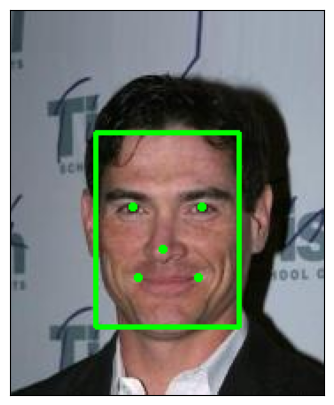

[{'box': [48, 69, 81, 110], 'confidence': 0.9994163513183594, 'keypoints': {'left_eye': (69, 111), 'right_eye': (108, 111), 'nose': (86, 135), 'mouth_left': (72, 151), 'mouth_right': (106, 151)}}, {'ratio': {'face': 8910, 'mouth': 0.6963006741828925, 'nose': 0.6153846153846154}}]


In [ ]:
men_satisfied_img, men_satisfied_idx, men_detected = show_random_img('man', men_detection, men_ratio_mouth, men_ratio_nose)
men_satisfied_img
print(men_detected)

In [ ]:
women_ratio_mouth = float(input('Enter the mouth ratio you want: '))
women_ratio_nose = float(input('Enter the nose ratio you want: '))

Enter the mouth ratio you want: 0.5
Enter the nose ratio you want: 0.5


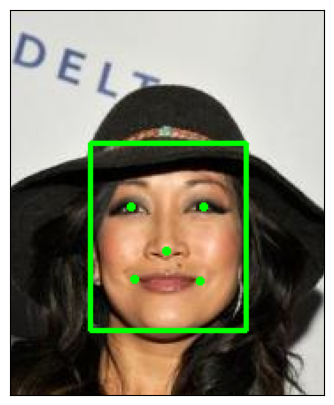

[{'box': [45, 75, 88, 106], 'confidence': 0.9997329115867615, 'keypoints': {'left_eye': (68, 111), 'right_eye': (109, 111), 'nose': (88, 136), 'mouth_left': (70, 152), 'mouth_right': (107, 153)}}, {'ratio': {'face': 9328, 'mouth': 0.6708396428702473, 'nose': 0.6097560975609756}}]


In [ ]:
women_satisfied_img, women_satisfied_idx, women_detected = show_random_img('woman', women_detection, women_ratio_mouth, women_ratio_nose)
women_satisfied_img
print(women_detected)

In [ ]:
def load_img(img_path, transform=None):
  img = Image.open(img_path).convert('RGB')
  img = img.resize([224, 224], Image.LANCZOS)

  if transform is not None:
    img = transform(img).unsqueeze(0)
  return img

encoder_path = './nic_encoder_ResNet152.ckpt'
decoder_path = './nic_decoder_ResNet152.ckpt'
vocab_path = './vocab.pkl'

embed_size = 256
hidden_size = 512
num_layers = 1

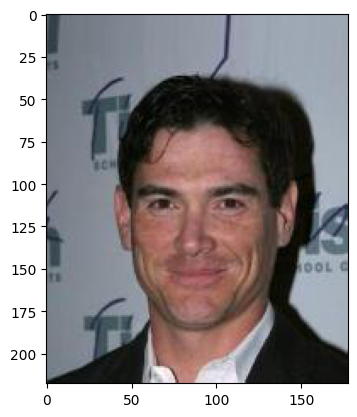

<start> a man in a black shirt and a woman in a black shirt and a woman in a black


In [ ]:
# selected men image captioning

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.255))])

with open(vocab_path, 'rb') as f:
  vocab = pickle.load(f)

encoder = Encoder(embed_size).eval()
decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

zero_men_satisfied_idx = str(men_satisfied_idx).zfill(6)
men_satisfied_img_path = f'./drive/MyDrive/AI-project/data/men/{zero_men_satisfied_idx}.jpg'
img = load_img(men_satisfied_img_path, transform)
img_tensor = img.to(device)

feature = encoder(img_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

sampled_caption = []
for word_id in sampled_ids:
  word = vocab.idx2word[word_id]
  sampled_caption.append(word)
  if word == '<end>':
    break
sentence = ' '.join(sampled_caption)

img = Image.open(men_satisfied_img_path)
plt.imshow(np.asarray(img))
plt.show()
print(sentence)

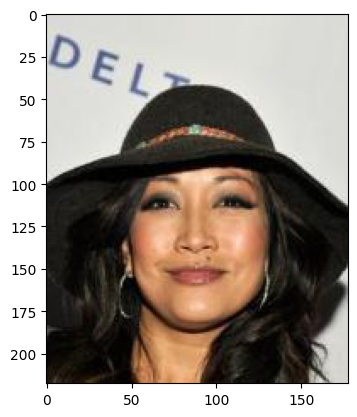

<start> a woman in a black jacket and a black hat and a white shirt . <end>


In [ ]:
# selected women image captioning

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.255))])

with open(vocab_path, 'rb') as f:
  vocab = pickle.load(f)

encoder = Encoder(embed_size).eval()
decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

zero_women_satisfied_idx = str(women_satisfied_idx).zfill(6)
women_satisfied_img_path = f'./drive/MyDrive/AI-project/data/women/{zero_women_satisfied_idx}.jpg'
img = load_img(women_satisfied_img_path, transform)
img_tensor = img.to(device)

feature = encoder(img_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

sampled_caption = []
for word_id in sampled_ids:
  word = vocab.idx2word[word_id]
  sampled_caption.append(word)
  if word == '<end>':
    break
sentence = ' '.join(sampled_caption)

img = Image.open(women_satisfied_img_path)
plt.imshow(np.asarray(img))
plt.show()
print(sentence)